In [1]:
'''
# 라이브러리 정의
 - 시스템 라이브러리
 - 오디오 관련 라이브러리
 - 연산 및 Plot 관련 라이브러리 
 - 샤용자 라이브러리
'''

# Import Systems 
import struct
import io
import os
import sys
import math
import platform

# Import Audio
import pyaudio
import librosa 
import soundfile

import numpy as np
import scipy
import scipy.signal as sig
import matplotlib.pyplot as plt

# User Libraries
import pyOssWavfile
import pyRoomAcoustic as room
import pyOssDebug as dbg
import pyOssFilter
import pyOssLearn as learn

#############################################################################
#  Impulse Data Load & -------------------------------------------------------#
#############################################################################

str_fileinfo = '_mono_32f_44.1k'    # 파일명에 부가된 정보

# IMPULSE WAVE FILE
# wav_name = "TyndallBruceMonument"
# wav_name = "ElvedenHallMarbleHall'"
# wav_name = "EmptyApartmentBedroom"
# wav_name = "FalklandPalaceRoyalTennisCourt"
# wav_name = "InsidePiano"
# wav_name = "MaesHowe"
# wav_name = "SportsCentreUniversityOfYork"
wav_name = "StairwayUniversityOfYork"
# wav_name = "StAndrewsChurch"
# wav_name = "mh3_000_ortf_48k"
# wav_name = "mh3_000_wx_48k"
# wav_name = "anechoic_gunshot_0.44.1kHz.f32"
# wav_name = "10s sweep for 3s reverb 48k"

dir_name = 'impulsefiles'

wav_fname= wav_name + str_fileinfo

fname = pyOssWavfile.str_fname(dir_name, wav_fname) # 전체경로, 파일명 조합

fmt_w, data_w, st_fmt_w, t_w = pyOssWavfile.readf32(fname)
print(t_w)

room.decayCurve(data_w, t_w, st_fmt_w.fs)

last_value = data_w[data_w.shape[0]-1]
print(last_value)

if t_w < 3.0:
    t_temp = 3.0 - t_w
    data = pyOssWavfile.insertSilence(data_w, st_fmt_w.fs, t_temp)
else:
    data = data_w

print(data.shape[0]/st_fmt_w.fs)


3.0
2.3841858e-07
3.0


0.032063492063492065


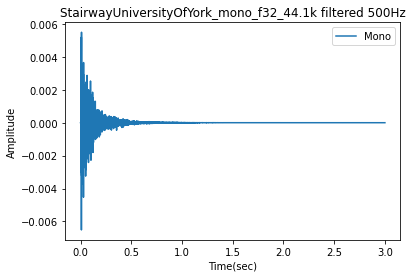

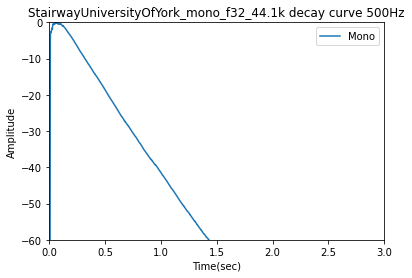

{'RT60': array([[1.254]]), 'EDT': array([[1.488]]), 'D50': 0.5620623948103148, 'C50': 1.0837229032726146, 'C80': 4.628038659465662}


In [2]:
###############################################################################
# Filter
###############################################################################

fc = 500        # Center freq for bandpass filter 500Hz

data_filt, decay, a_param, c_param = pyOssFilter.calc_filt_impulse_learning(1, data, st_fmt_w.fs, fc, fname=wav_fname)

print(a_param.__dict__)



tgt_rt60 = 2.5      # unit: sec
sample_tgt_rt60 = c_param.s_0dB + int(st_fmt_w.fs * tgt_rt60)
print(c_param.s_0dB, sample_tgt_rt60)

k = 1
draw_plot = False



p_0dB = c_param.s_0dB
p_10dB = c_param.s_10dB
p_20dB = c_param.s_20dB
p_30dB = c_param.s_30dB

gain_slope_a = np.ones(p_0dB, dtype='f')
gain_slope_b = np.linspace( 1.0, 1.3, num=(data_filt.shape[0]-p_0dB) )
# gain_slope_b = np.logspace( 0, 0.2, num=(data_filt.shape[0]-p_0dB) )
gain_slope = np.append( gain_slope_a, gain_slope_b )
data_temp = data_filt * gain_slope
data_filt, decay, a_param, c_param  = \
            learn.learning_decay(False, data_temp, st_fmt_w.fs, fc, fname=wav_fname)

k = k + 1
print (k, " : ",  a_param.RT60[0][0])
print ("      ",  p_0dB, p_10dB, p_20dB, p_30dB)

dbg.dPlotAudio(st_fmt_w.fs, data_temp)
dbg.dPlotDecay(st_fmt_w.fs, decay)


... <  2.5
2  :  1.288
       9612 14039 23214 32516
3  :  1.328
       9612 14054 23365 33007
4  :  1.374
       9612 14071 23585 33644
5  :  1.44
       9612 14088 23786 34444
6  :  1.526
       9612 14105 23993 35191
7  :  1.626
       9612 14123 24212 36253
8  :  1.74
       9612 14142 24661 37127
9  :  1.88
       9612 14163 25006 38647
10  :  2.042
       9612 14185 25472 41355
11  :  2.26
       9612 14228 25904 44165
12  :  2.556
       9612 14264 26541 46597
=== Stop, k =  12

2-1. __dict__ =  {'RT60': array([[2.556]]), 'EDT': array([[1.5]]), 'D50': 0.4951995294900155, 'C50': -0.08339527658918489, 'C80': 2.789784305078329}
2-2. acoustic_w_param.RT60[0][0] =  2.556

2-3. __dict__ =  {'s_0dB': 9612, 's_10dB': 14288, 's_20dB': 27123, 's_30dB': 49599}
2-4. sample_w_dB_param.s_0dB =  9612
2-5. sample_w_dB_param.s_10dB =  14288
2-6. sample_w_dB_param.s_20dB =  27123
2-7. sample_w_dB_param.s_30dB =  49599


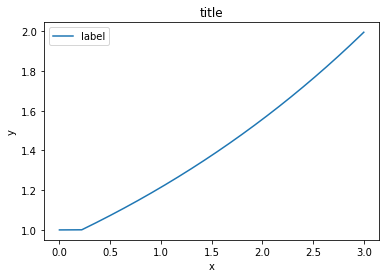

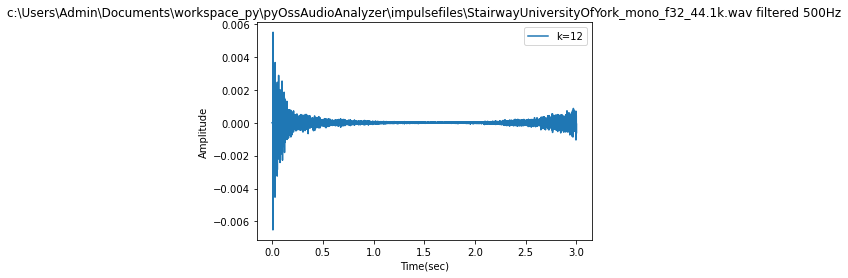

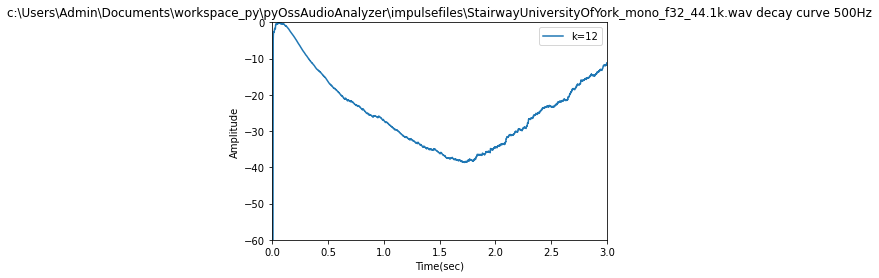

In [4]:
###############################################################################
#
###############################################################################
draw_plot = False

tgt_rt60 = 2.5      # sec
sample_tgt_rt60 = c_param.s_0dB + int(st_fmt_w.fs * tgt_rt60)


k = 1
if a_param.RT60[0][0] > tgt_rt60:
    print("... > ", str(tgt_rt60))
    while a_param.RT60[0][0] > tgt_rt60:

        # data_w2 각 구간별 위치 구한 후 각 구각에 data_w*1.4, *1.2 *1 계산
        # 위치 찾기
        p_0dB = c_param.s_0dB
        p_10dB = c_param.s_10dB
        p_20dB = c_param.s_20dB
        p_30dB = c_param.s_30dB

        '''
        #case 1
        data_w_filtered = data_w_filtered * 0.8
        data_w = data_w_filtered

        if k == 26:
            draw_plot = True
        else:
            draw_plot = False

        data_w_filtered, decaycurve_w_filtered, acoustic_w_param, sample_w_dB_param  = \
            pyOssFilter.calc_filt_impulse_learning(draw_plot, data_w, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname + str_fileinfo)
        '''
        '''
        #case 2
        if p_10dB > p_0dB and p_30dB > 0:
            data_filt[0:p_10dB] = data_filt[0:p_10dB] * 0.9

            if p_20dB > p_10dB:
                data_filt[p_10dB:] = data_filt[p_10dB:] * 0.7

            data_temp = data_filt
            if k == 26:
                draw_plot = True
            else:
                draw_plot = False

            data_filt, decay, a_param, c_param  = \
                pyOssFilter.calc_filt_impulse_learning(draw_plot, data_temp, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname)
        '''
        '''
        #case 3
        if p_10dB > p_0dB and p_30dB > 0:
            data_w_filtered[0:p_10dB] = data_w_filtered[0:p_10dB] * 0.8

            if p_20dB > p_10dB:
                data_w_filtered[p_10dB:p_20dB] = data_w_filtered[p_10dB:p_20dB] * 0.5

            if p_30dB > p_20dB:
                data_w_filtered[p_20dB:p_30dB] = data_w_filtered[p_20dB:p_30dB] * 0.3

            data_w = data_w_filtered
            if k == 26:
                draw_plot = True
            else:
                draw_plot = False

            data_w_filtered, decaycurve_w_filtered, acoustic_w_param, sample_w_dB_param  = \
                pyOssFilter.calc_filt_impulse_learning(draw_plot, data_w, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname + str_fileinfo)
        '''
        #case 4 (oss)
        gain_slope_a = np.ones(p_0dB, dtype='f')
        print( len(gain_slope_a) )
        # gain_slope_b = np.linspace( 1.0, 0.7, num=(data_filt.shape[0]-p_0dB) )
        gain_slope_b = np.logspace( 0, -0.3, num=(data_filt.shape[0]-p_0dB) )
        gain_slope = np.append( gain_slope_a, gain_slope_b )
        data_temp = data_filt * gain_slope
        data_filt, decay, a_param, c_param  = \
            learn.learning_decay(draw_plot, data_temp, st_fmt_w.fs, fc, fname=wav_fname)

        if a_param.RT60[0][0] == 0.0 or k > 1000:
            break

        k = k + 1
        # if k <= 50 or k % 50 == 0:
        #     print (k, " : ",  a_param.RT60[0][0])
        #     print ("      ",  p_0dB, p_10dB, p_20dB, p_30dB)
        print (k, " : ",  a_param.RT60[0][0])
        print ("      ",  p_0dB, p_10dB, p_20dB, p_30dB)

else:
    print("... < ", str(tgt_rt60))
    while a_param.RT60[0][0] < tgt_rt60:

        # data_w2 각 구간별 위치 구한 후 각 구각에 data_w*1.4, *1.2 *1 계산
        # 위치 찾기
        p_0dB = c_param.s_0dB
        p_10dB = c_param.s_10dB
        p_20dB = c_param.s_20dB
        p_30dB = c_param.s_30dB

        '''
        #case 1
        data_w_filtered = data_w_filtered * 1.2

        data_w = data_w_filtered

        if k == 50:
            draw_plot = True
        else:
            draw_plot = False

        data_w_filtered, decaycurve_w_filtered, acoustic_w_param, sample_w_dB_param  = \
            pyOssFilter.calc_filt_impulse_learning(draw_plot, data_w, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname + str_fileinfo)

        '''
        '''
        #case 2
        if p_10dB > p_0dB and p_30dB > 0:
            data_filt[0:p_10dB] = data_filt[0:p_10dB] * 1.0

            if p_20dB > p_10dB:
                data_filt[p_10dB:] = data_filt[p_10dB:] * 1.1

            data_temp = data_filt

            if k == 29:   
                draw_plot = True
            else:
                draw_plot = False


            data_filt, decay, a_param, c_param  = \
                pyOssFilter.calc_filt_impulse_learning(draw_plot, data_temp, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname + str_fileinfo)
        '''
        '''
        #case 3

        if p_10dB > p_0dB and p_30dB > 0:
            data_w_filtered[0:p_10dB] = data_w_filtered[0:p_10dB] * 1.1

            if p_20dB > p_10dB:
                data_w_filtered[p_10dB:p_20dB] = data_w_filtered[p_10dB:p_20dB] * 1.2

            if p_30dB > p_20dB:
                data_w_filtered[p_20dB:p_30dB] = data_w_filtered[p_20dB:p_30dB] * 1.5

            data_w = data_w_filtered

            if k == 26:
                draw_plot = True
            else:
                draw_plot = False

            data_w_filtered, decaycurve_w_filtered, acoustic_w_param, sample_w_dB_param  = \
                pyOssFilter.calc_filt_impulse_learning(draw_plot, data_w, st_fmt_w.fs, fc, filt_type='butt',fname=wav_fname + str_fileinfo)
        '''

        #case 4 
        gain_slope_a = np.ones(p_0dB, dtype='f')
        # gain_slope_b = np.linspace( 1.0, 1.3, num=(data_filt.shape[0]-p_0dB) )
        gain_slope_b = np.logspace( 0, 0.3, num=(data_filt.shape[0]-p_0dB) )
        gain_slope = np.append( gain_slope_a, gain_slope_b )
        data_temp = data_filt * gain_slope
        data_filt, decay, a_param, c_param  = \
            learn.learning_decay(draw_plot, data_temp, st_fmt_w.fs, fc, fname=wav_fname)

        if a_param.RT60[0][0] == 0.0 or k > 1000:
            print("K IS ==== ", k)
            break

        k = k + 1
        # if k <= 50 or k % 50 == 0:
        #     print (k, " : ",  a_param.RT60[0][0])
        #     print ("      ",  p_0dB, p_10dB, p_20dB, p_30dB)
        print (k, " : ",  a_param.RT60[0][0])
        print ("      ",  p_0dB, p_10dB, p_20dB, p_30dB)

print("=== Stop, k = ", k)
# print("2-1. acoustic_w_param = ", acoustic_w_param)
# print('1. inspect = ', inspect.getmembers(acoustic_w_param))
print('\n2-1. __dict__ = ', a_param.__dict__)
print('2-2. acoustic_w_param.RT60[0][0] = ', a_param.RT60[0][0])
print('\n2-3. __dict__ = ', c_param.__dict__)
print('2-4. sample_w_dB_param.s_0dB = ', c_param.s_0dB)
print('2-5. sample_w_dB_param.s_10dB = ', c_param.s_10dB)
print('2-6. sample_w_dB_param.s_20dB = ', c_param.s_20dB)
print('2-7. sample_w_dB_param.s_30dB = ', c_param.s_30dB)

dbg.dPlotAudio(st_fmt_w.fs, gain_slope)
dbg.dPlotAudio( st_fmt_w.fs, data_filt, fname + ' filtered ' + str(fc) + 'Hz', label_txt='k='+str(k), xl_txt="Time(sec)", yl_txt="Amplitude" )
dbg.dPlotDecay( st_fmt_w.fs, decay, fname + ' decay curve ' + str(fc) + 'Hz', label_txt='k='+str(k), xl_txt="Time(sec)", yl_txt="Amplitude" )

